- how to get metric depth
    - finetune the model on depth regression 
        - init encoder of downstream MDE model with this one's pre-trained encoder params (vit-l)
        - leave decoder random init (dpt)
        - fine-tune with corresponding metric depth info

- why disparity instead of direct depth regression
    - more robust and sharper depth
    - easier to handle scale and shift ambiguities
        - this predicts relative depth instead of absolute depth. it is necessary because different scenes have different depth range (think outdoors vs indoors)
        - disparity is inversely proportional to depth
            - closer objects have larger distance in stereo image pair
        - scale and shift ambiguities can be represented as linear transformations
            - easier to model and train
            - eg. a = 2meters, b = 4meters . invert it a = 0.5, b = 0.25 . scale by 2 and shift by 0.5 . a = 1.1, b = 0.6 . a is still larger than b (closer to camera)
            - after converting back only relative relationship is maintained eg. a = 1/1.1m = 0.91m, b = 1/0.6 = 1.67m
        - not using the disparity space makes it hard to get the original scale back

- loss
    - labeled
        - scale and shift invariant loss
            - used to make model learn relative depth relations
                - invert depth
                - normalize (to make ground truth and prediction have unit scale and shift)
        - gradient matching 
            - much more important with synthetic image depth sharpness
                - like edge detector
            - not used in DA v1
            - how
                - aligning the gradient depth map of predicted with that of ground truth
                - apply loss at gradient level
                - apply this at multiple levels
    - pseudo labeled
        - feature alignment loss

In [7]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

from depth_anything_v2.dpt import DepthAnythingV2

# Outdoor

In [4]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitl' # or 'vits', 'vitb'
dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 80 # 20 for indoor model, 80 for outdoor model

model = DepthAnythingV2(**{**model_configs[encoder]})
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
model.eval()

In [5]:
raw_img = cv2.imread('./assets/examples/demo01.jpg')
depth = model.infer_image(raw_img) # HxW depth map in meters in numpy

C:\Users\adity\AppData\Local\Temp\ipykernel_18524\553254455.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'checkpoints/depth_anything

In [11]:
print("Number of unique depth values: ", len(np.unique(depth)))
print("Range of unique depth values: ", np.min(depth), np.max(depth))

Number of unique depth values:  920560
Range of unique depth values:  0.0 4.799913


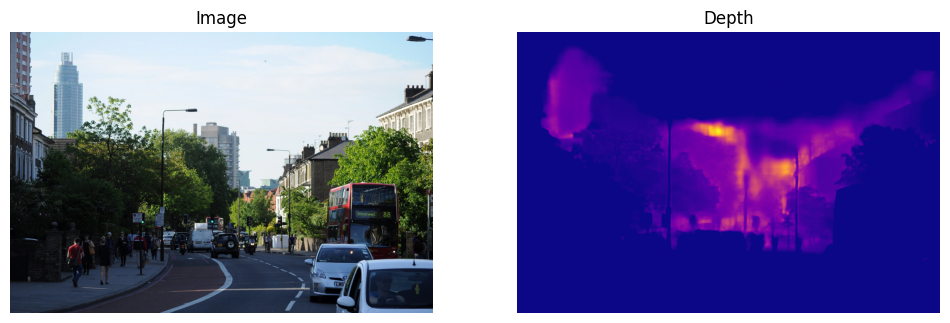

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Image')
ax1.axis('off')
ax2.imshow(depth, cmap='plasma')
ax2.set_title('Depth')
ax2.axis('off')
plt.show()

# Indoor

In [ ]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitl' # or 'vits', 'vitb'
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 20 # 20 for indoor model, 80 for outdoor model

model = DepthAnythingV2(**{**model_configs[encoder]})
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
model.eval()

In [16]:
raw_img = cv2.imread('./assets/examples/demo01.jpg')
depth = model.infer_image(raw_img) # HxW depth map in meters in numpy

In [17]:
print("Number of unique depth values: ", len(np.unique(depth)))
print("Range of unique depth values: ", np.min(depth), np.max(depth))

Number of unique depth values:  1721283
Range of unique depth values:  0.0 4.263522


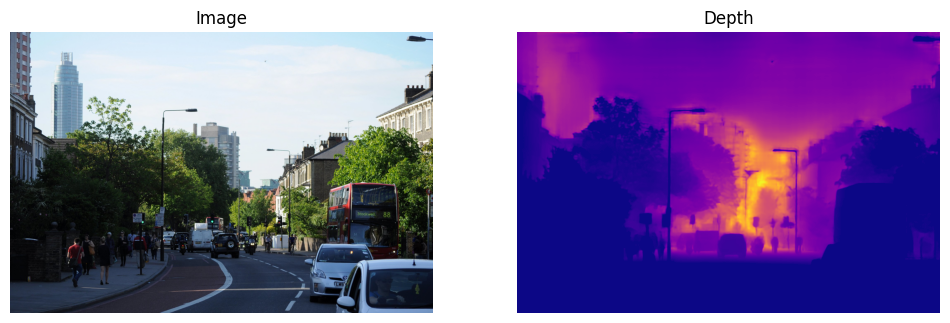

In [18]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Image')
ax1.axis('off')
ax2.imshow(depth, cmap='plasma')
ax2.set_title('Depth')
ax2.axis('off')
plt.show()